In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

train_df = pd.read_csv(r"C:\Users\kokki\Downloads\playground-series-s6e2\train.csv")
test_df =pd.read_csv(r"C:\Users\kokki\Downloads\playground-series-s6e2\test.csv")


In [25]:
train_df.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [26]:

train_df.drop("id", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

print(train_df.shape)
print(train_df.isnull().sum())
print("Duplicates:", train_df.duplicated().sum())


(630000, 14)
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64
Duplicates: 0


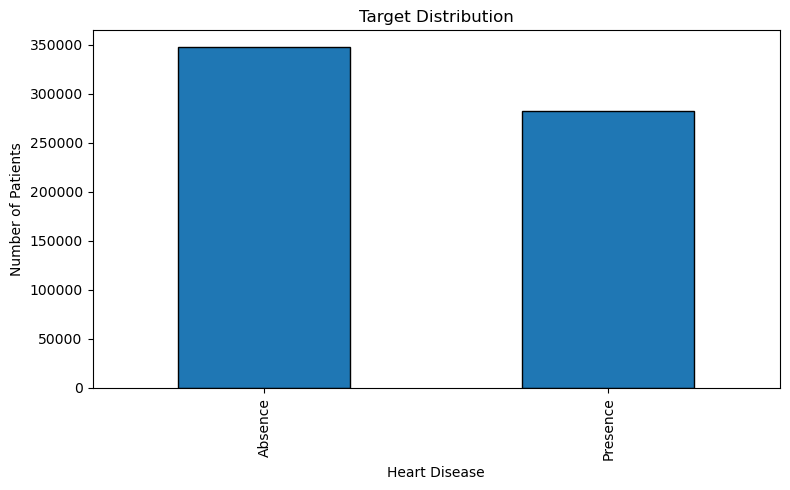

In [27]:
plt.figure(figsize=(8,5))
train_df['Heart Disease'].value_counts().sort_index().plot(
    kind='bar', edgecolor='black'
)
plt.xlabel("Heart Disease")
plt.ylabel("Number of Patients")
plt.title("Target Distribution")
plt.tight_layout()
plt.show()


In [28]:
label_encoder = LabelEncoder()
train_df['Heart Disease'] = label_encoder.fit_transform(train_df['Heart Disease'])

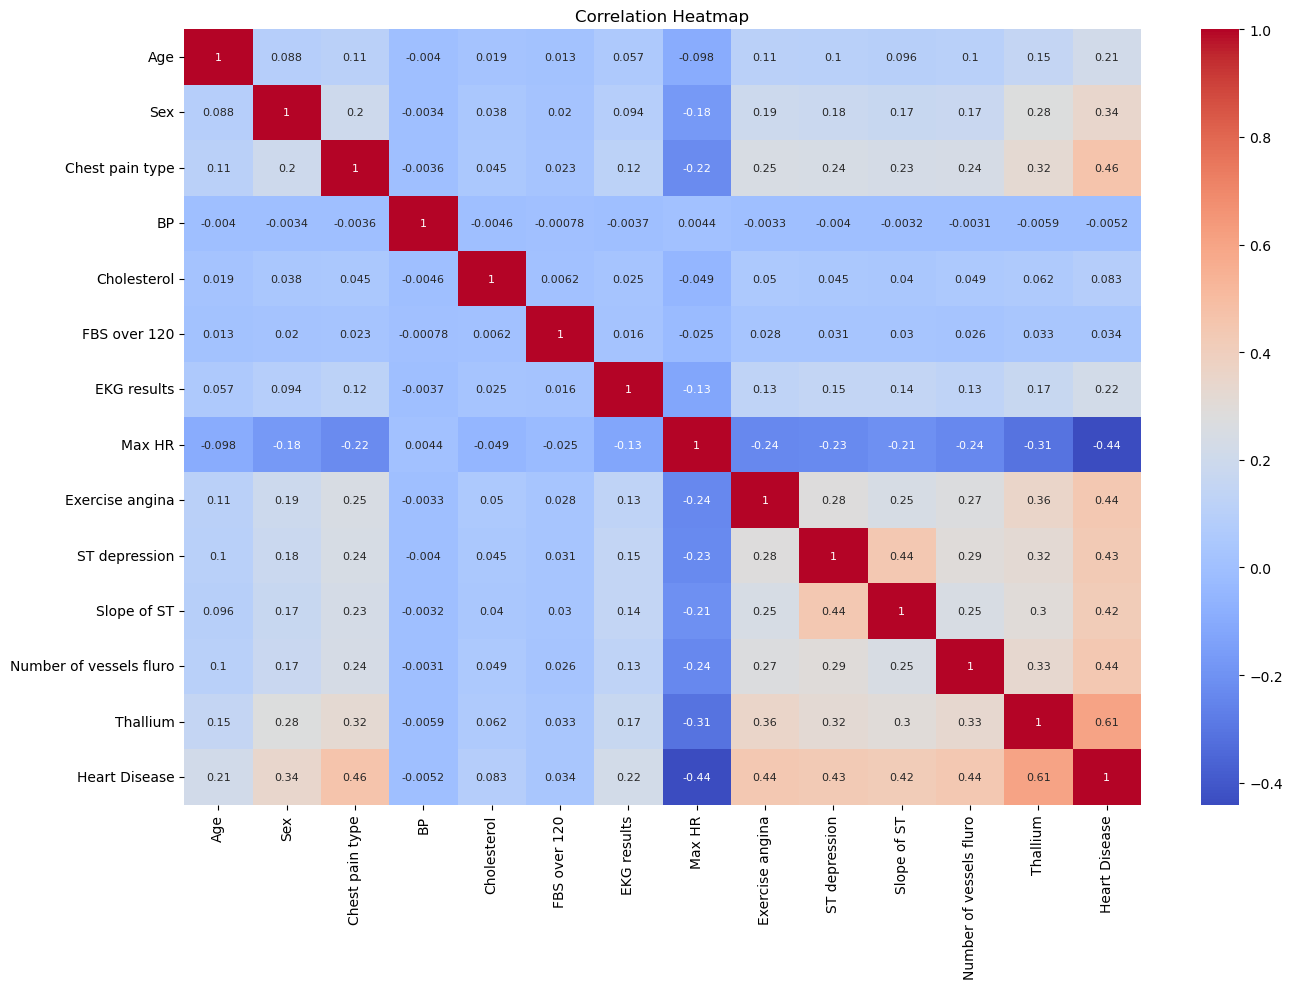

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm',annot_kws={"size": 8} )
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [30]:
corr = train_df.corr()['Heart Disease']
influence = (corr.abs()*100)
print(influence)

Age                         21.209131
Sex                         34.244626
Chest pain type             46.068360
BP                           0.518103
Cholesterol                  8.275283
FBS over 120                 3.357028
EKG results                 21.896133
Max HR                      44.098542
Exercise angina             44.186373
ST depression               43.064059
Slope of ST                 41.505024
Number of vessels fluro     43.860354
Thallium                    60.577639
Heart Disease              100.000000
Name: Heart Disease, dtype: float64


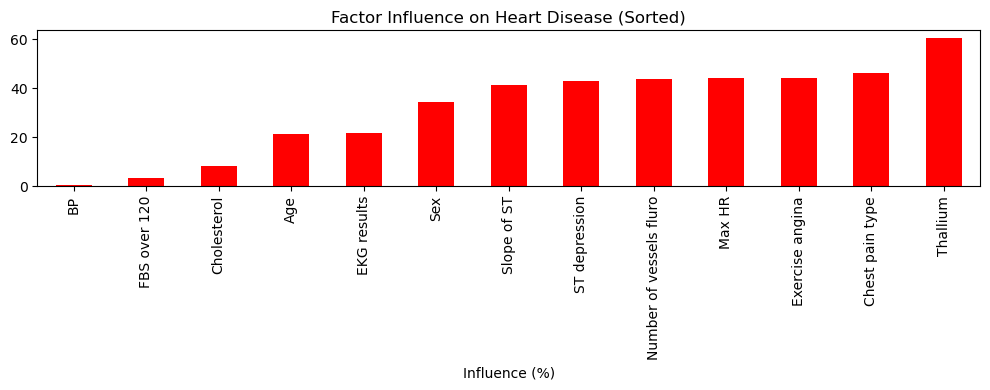

In [31]:
plt.figure(figsize=(10,4))
influence.drop('Heart Disease').sort_values().plot(kind='bar',color='red')
plt.xlabel("Influence (%)")
plt.title("Factor Influence on Heart Disease (Sorted)")
plt.tight_layout()
plt.show()

In [32]:
train_df.nunique()

Age                         42
Sex                          2
Chest pain type              4
BP                          66
Cholesterol                150
FBS over 120                 2
EKG results                  3
Max HR                      93
Exercise angina              2
ST depression               66
Slope of ST                  3
Number of vessels fluro      4
Thallium                     3
Heart Disease                2
dtype: int64

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: f

In [34]:
train_df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873,0.448340
std,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007,0.497324
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000,0.000000
75%,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [35]:
hd1 = train_df[train_df['Heart Disease'] == 1]
hd0 = train_df[train_df['Heart Disease'] == 0]

summary = pd.DataFrame({
    'Mean_HD=1': hd1.mean(numeric_only=True),
    'Median_HD=1': hd1.median(numeric_only=True),
    'Mean_HD=0': hd0.mean(numeric_only=True),
    'Median_HD=0': hd0.median(numeric_only=True)
})

summary.drop('Heart Disease')


,Mean_HD=1,Median_HD=1,Mean_HD=0,Median_HD=0
Age,56.079114,57.0,52.558093,52.0
Sex,0.886258,1.0,0.575337,1.0
Chest pain type,3.747941,4.0,2.959070,3.0
BP,130.411366,130.0,130.567381,130.0
Cholesterol,248.103585,246.0,242.499102,239.0
FBS over 120,0.090089,0.0,0.071778,0.0
EKG results,1.224249,2.0,0.784506,0.0
Max HR,143.467372,146.0,160.415105,162.0
Exercise angina,0.492264,0.0,0.096117,0.0
ST depression,1.169104,1.2,0.347808,0.0


In [36]:
TARGET_COL = "Heart Disease"

X_train = train_df.drop(TARGET_COL, axis=1)
y_train = train_df[TARGET_COL]

X_test = test_df.copy()   


In [37]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=3000, n_jobs=-1))
    ]),
    
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=8,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    
    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("model", XGBClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        ))
    ])
}


In [38]:
print("\n🔹 Cross-Validation ROC-AUC (Train Data)")

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1
    )
    cv_results[name] = scores.mean()
    print(f"{name}: CV ROC-AUC = {scores.mean():.4f}")



🔹 Cross-Validation ROC-AUC (Train Data)
Logistic Regression: CV ROC-AUC = 0.9505
Random Forest: CV ROC-AUC = 0.9509
XGBoost: CV ROC-AUC = 0.9546


In [39]:
best_model_name = max(cv_results, key=cv_results.get)
best_model = models[best_model_name]

best_model.fit(X_train, y_train)

test_predictions = best_model.predict_proba(X_test)[:, 1]

print("Best Model:", best_model_name)
print("Test predictions generated ")


Best Model: XGBoost
Test predictions generated 


In [41]:
test_df = pd.read_csv(r"C:\Users\kokki\Downloads\playground-series-s6e2\test.csv")
test_ids = test_df['id']  


submission = pd.DataFrame({
    "id": test_ids,
    "target": test_predictions 
})

submission.to_csv("submission.csv", index=False)
print("Submission file created ")


Submission file created 


In [40]:
import joblib


joblib.dump(best_model, "best_model_pipeline.pkl")
print("Model saved ")


Model saved 
